In [1]:
import os
import cooler
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore
from scipy import ndimage as nd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from itertools import cycle, islice
import xarray as xr
from glob import glob
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#mpl.rcParams['font.family'] = 'sans-serif'
#mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [2]:
ct = 'Oligo_NN'
leg = [f"{ct}.{age}" for age in ['8wk','9mo','18mo']]
leg

['Oligo_NN.8wk', 'Oligo_NN.9mo', 'Oligo_NN.18mo']

In [3]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:-1]

In [4]:
indir = '/data/female-amb/loop/'
ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'

In [5]:
genemeta = pd.read_csv('/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t', index_col = 'gene_name')
genemeta = genemeta[~genemeta.index.duplicated(keep='first')]
genemeta.head()

,chrom,source,feature,start,end,score,strand,phase,gene_id,transcript_id,...,gene_status,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
gene_name,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,chr1,HAVANA,gene,3073253,3074322,.,+,.,ENSMUSG00000102693.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
Gm26206,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,ENSMUSG00000064842.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
Xkr4,chr1,HAVANA,gene,3205901,3671498,.,-,.,ENSMUSG00000051951.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
Gm18956,chr1,HAVANA,gene,3252757,3253236,.,+,.,ENSMUSG00000102851.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
Gm37180,chr1,HAVANA,gene,3365731,3368549,.,-,.,ENSMUSG00000103377.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN


In [6]:
gtmp = 'Il33'


chrom = genemeta.loc[gtmp, 'chrom']
if genemeta.loc[gtmp, 'strand']=='+':
    tss = genemeta.loc[gtmp, 'start'] -2000
    tes = genemeta.loc[gtmp, 'end'] + 2000
else:
    tss = genemeta.loc[gtmp, 'end'] -2000
    tes = genemeta.loc[gtmp, 'start'] +2000

print(f"{gtmp}:{tss}, {tes}")


Il33:29923114, 29962718


In [8]:
#tss, tes = tss -2000, tes + 2000
lslop, rslop = 300000, 300000
ll, rr = (tss - lslop), (tes + rslop)
region = f"{chrom}:{ll}-{rr}"
region

'chr19:29623114-30262718'

In [9]:
resl = 10000
loopl, loopr = (ll//resl), (rr//resl)
print(loopl, loopr)

2962 3026


In [10]:
dstall = []
resolution = 5000

for group in leg:
    #cool = cooler.Cooler(f'/data/female-amb/AMB.CoolFiles/CellType.Age.Region.Raw.5kb/{group}.cool')
    #cool = cooler.Cooler(f'/data/female-amb/AMB.CoolFiles/CellType.Age.Raw.5kb.mcool/{group}.raw.mcool::resolutions/{resolution}')
    cool = cooler.Cooler(f'/data/female-amb/loop/{group}/{group}/{group}.Q.cool')

    Q = cool.matrix(balance=False, sparse=True).fetch(region).toarray()
    Q = Q - np.diag(np.diag(Q))
    dst = nd.rotate(Q, 45, order=0, reshape=True, prefilter=False, cval=0)
    dstall.append(dst)

In [11]:
## select differential loop
loopall = pd.read_hdf(f'{ldir}/merged_loop.hdf', key='data')
sell = ((loopall[0]==chrom) & 
        (zscore(np.log(loopall['Qanova']))>norm.isf(0.3)) & 
        (zscore(np.log(loopall['Tanova']))>norm.isf(0.3)) & 
        (loopall[1]>ll) & (loopall[5]<rr))
print(sell.sum())

30


Text(0.5, 0.98, 'Il33 chr19:29623114-30262718 0-0.022')

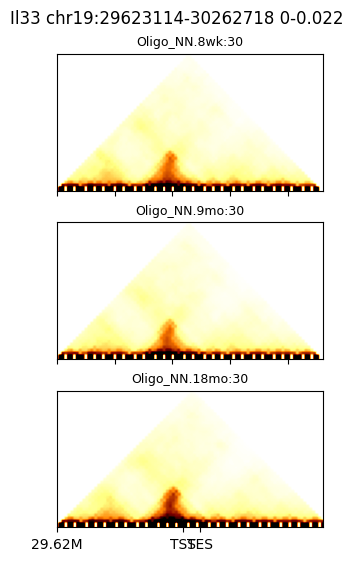

In [17]:
fig, axes = plt.subplots(nrows = 3, figsize=(3, 5.5), constrained_layout = True, dpi = 100)
vmin = 0
vmax  = 0.022

tmpl = loopall.loc[sell, [1,4]].values // resl - loopl
#tmpl= tmpl * (resl//resolution)

for i , ax in zip(range(len(leg)),axes.ravel()):
    ax.axis('equal')
    ax.set_title(f"{leg[i]}:{sell.sum()}", fontsize=9)
    
    #img = ax.imshow(dstall[i][:dstall[i].shape[0]//2], cmap='afmhot_r', vmin=0, vmax=30, aspect='auto')
    img = ax.imshow(dstall[i], cmap='afmhot_r', vmin=vmin, vmax=vmax, aspect='auto') #afmhot_r
    h = len(dstall[i])
    ax.set_ylim([0.5*h, 0*h])
    ax.set_xlim([0, h])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    ## plot diff loop
    # ax.scatter((tmpl[:, 0]+tmpl[:, 1])/np.sqrt(2), 0.5*h-(tmpl[:, 1]-tmpl[:, 0])/np.sqrt(2), 
    #        alpha=0.15, s=3, marker='D', edgecolors='c', color='none')
 
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])
ax.set_xticks(np.sqrt(2)*np.array(np.arange(0, loopr-loopl+1, 100).tolist() + [tss//resl-loopl, tes//resl-loopl]))
ax.set_xticklabels([])
ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl+1, 100)]+['TSS','TES'])
plt.suptitle(f"{gtmp} {region} {vmin}-{vmax}") 

#fig.savefig(f'figure/{ct}.{gtmp}.Hic.Example.pdf', transparent=True, bbox_inches = 'tight')


In [164]:
# fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize=(10, 6), constrained_layout = True, dpi = 300)
# vmin = 0
# vmax = 9

# for i , ax in zip(range(len(leg)),axes.ravel()):
#     ax.axis('equal')
#     ax.set_title(leg[i], fontsize=9)
    
#     #img = ax.imshow(dstall[i][:dstall[i].shape[0]//2], cmap='afmhot_r', vmin=0, vmax=30, aspect='auto')
#     img = ax.imshow(dstall[i], cmap='afmhot_r', vmin=vmin, vmax=vmax, aspect='auto') #afmhot_r
#     h = len(dstall[i])
#     ax.set_ylim([0.5*h, 0.2*h])
#     ax.set_xlim([0, h])
#     ax.set_yticks([])
#     ax.set_yticklabels([])


#     mid_point = dstall[i].shape[1] // 2  # Since we're only showing the upper half
    
#     # Set the x-ticks and labels
#     ax.set_xticks([mid_point])
#     ax.set_xticklabels([gtmp])
# plt.suptitle(f"{region} {vmin}-{vmax}")  
# #fig.savefig(f'Fig1.Il33.Hic.Example.pdf', transparent=True, bbox_inches = 'tight')

In [156]:
# fig, axes = plt.subplots(ncols = 1, nrows = len(leg), figsize=(5, 6), constrained_layout = True, dpi = 100)
# vmin = 2
# vmax = 10
# for i in range(len(leg)):
#     ax = axes[i]
#     ax.axis('equal')
#     ax.set_title(leg[i], fontsize=9)
    
#     #img = ax.imshow(dstall[i][:dstall[i].shape[0]//2], cmap='afmhot_r', vmin=0, vmax=30, aspect='auto')
#     img = ax.imshow(dstall[i], cmap='afmhot_r', vmin=vmin, vmax=vmax, aspect='auto') #afmhot_r
#     h = len(dstall[i])
#     ax.set_ylim([0.5*h, 0.2*h])
#     ax.set_xlim([0, h])
#     ax.set_yticks([])
#     ax.set_yticklabels([])


#     mid_point = dstall[i].shape[1] // 2  # Since we're only showing the upper half
    
#     # Set the x-ticks and labels
#     ax.set_xticks([mid_point])
#     ax.set_xticklabels([gtmp])
# plt.suptitle(f"{region} {vmin}-{vmax}")  
# #fig.savefig(f'Fig1.Il33.Hic.Example.pdf', transparent=True, bbox_inches = 'tight')

In [117]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors
# import matplotlib.colorbar as mcolorbar

# # Define the data range
# vmin = 1
# vmax = 30

# # Create a colormap
# cmap = plt.cm.afmhot_r

# # Create a normalization based on the data range
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# # Create a figure and axis for the plot
# fig, ax = plt.subplots(figsize=(2, 6))

# # Create a colorbar
# cbar = mcolorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

# # Set the colorbar ticks and labels
# cbar.set_ticks([vmin, vmax])
# cbar.set_ticklabels([f'{vmin}', f'{vmax}'])

# fig.savefig(f'Il33.Hic.colorbar.pdf', transparent=True, bbox_inches = 'tight')